<a href="https://colab.research.google.com/github/mopala/ML-DL/blob/main/Mnist/KNN_with_lsh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are doing KNN with locality-sensitive hasing, where our hash function is H(x) and it is given by logical and operation of some number (in our case 3) hash functions h_i(x), given by formula h_i(x)=sgn(x*p),where * means dot product and p is some random vector.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import scipy.stats as sstats
import seaborn as sns
from sklearn import datasets
import tensorflow as tf

In [2]:
mnist=tf.keras.datasets.mnist
(X_train,y_train),(X_test,y_test)=mnist.load_data()
x_train=np.array(X_train)
x_train=x_train.reshape([-1,28,28,1])
x_train=x_train/255
x_test=np.array(X_test)
x_test=x_test/255
x_test=x_test.reshape([-1,28,28,1])

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
x_train_partial=x_train[0:50000,:,:,:]
x_val=x_train[50000:60000,:,:,:]
y_train_partial=y_train[0:50000]
y_val=y_train[50000:60000]
print(x_train_partial.shape)
print(x_val.shape)
print(y_train_partial.shape)
print(y_val.shape)
print(y_train.shape)

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(50000,)
(10000,)
(60000,)


In [4]:
def err_rates(preds, test_Y):
    ret = {}
    for k, preds_k in  preds.items():
        pom= preds_k != test_Y
        ret[k] = sum(pom)/len(test_Y)
    return ret

In [5]:
def get_vector():
    return np.random.rand(784,1)*2-1
def hasz(x,p):
    l=np.dot(x,p)
    if(l>=0):
        return 1
    else:
        return -1
def dist_matrix(A,B):
    n1,m1=A.shape
    n2,m2=B.shape
    dists = np.matmul(A,B.T)/np.linalg.norm(A,axis=1,keepdims=True)/np.linalg.norm(B.T,axis=0,keepdims=True)
    return dists

In [6]:
def KNN_1(train_X, train_Y, test_X, ks):
    preds = {}

    if len(test_X)==0:
        for k in ks:
            preds[k]=[]
        return preds
    if len(train_X)==0:
        for k in ks:
            preds[k]=[0 for i in range(test_X.size)]        
        return preds
    train_X=np.array(train_X)
    test_X=np.array(test_X)
    train_Y=np.array(train_Y)
    train_X = train_X.astype(np.float32)
    test_X = test_X.astype(np.float32)

    dists=-dist_matrix(test_X,train_X)
    assert(dists.any()>=0)
    closest = np.argsort(dists)
    
    targets = train_Y[closest]
    for k in ks:
        predictions = sstats.mode(targets[:,0:k],axis=1)
        predictions=predictions[0]
        predictions = predictions.ravel()
        preds[k] = predictions

    return preds

In [10]:
def KNN_with_lsh(train_X, train_Y, test_X, ks,ile):
    train_X=np.array(train_X)
    test_X=np.array(test_X)
    train_Y=np.array(train_Y)
    train_X = train_X.astype(np.float32)
    test_X = test_X.astype(np.float32)
    preds = {-1:{},1:{}}

    Ntrain= train_X.shape[0]
    Ntest=test_X.shape[0]
    buckets_X_train={-1:[],1:[]}
    buckets_X_test={-1:[],1:[]}
    buckets_Y_train={-1:[],1:[]}
    p=get_vector()
    dict={}
    for i in range(Ntrain):
        h=hasz(train_X[i,:],p)
        buckets_X_train[h].append(train_X[i,:])
        buckets_Y_train[h].append(train_Y[i])
    dict_h={-1:-1,1:-1}
    for i in range(Ntest):
        h=hasz(test_X[i,:],p)
        dict_h[h]+=1
        dict[i]=[h,dict_h[h]]
        buckets_X_test[h].append(test_X[i,:])

    if ile==0:
        preds_1=KNN_1(buckets_X_train[-1],buckets_Y_train[-1],buckets_X_test[-1],ks)
        preds_2=KNN_1(buckets_X_train[1],buckets_Y_train[1],buckets_X_test[1],ks)
    else:
        preds_1=KNN_with_lsh(buckets_X_train[-1],buckets_Y_train[-1],buckets_X_test[-1],ks,ile-1)
        preds_2=KNN_with_lsh(buckets_X_train[1],buckets_Y_train[1],buckets_X_test[1],ks,ile-1)
    preds={}
    for k in ks:
        lista=[0 for i in range(Ntest)]
        lista1=preds_1[k]
        lista2=preds_2[k]

        for i in range(Ntest):
            h,nr=dict[i]
            if h==-1:
                lista[i]=lista1[nr]
            else:
                lista[i]=lista2[nr]
        preds[k]=np.array(lista)
    return preds

In [33]:
def batched_KNN(train_X, train_Y, test_X, ks, ile=3, batch_size=10000,verbose=False, ):
    all_preds = {k: [] for k in ks}
    for i in tqdm(range(0, test_X.shape[0], batch_size)):
        batch_X = test_X[i:i + batch_size]
        res=KNN_with_lsh(train_X,train_Y,batch_X,ks,4)
        for k in all_preds.keys():
            res[k]=res[k].reshape(batch_size,1)
            if i==0:
                all_preds[k]=res[k]
            else:
                all_preds[k] = np.concatenate((all_preds[k],res[k]))
    return all_preds

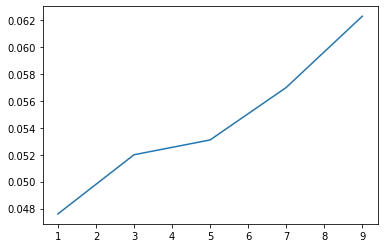

In [34]:
ks = [1, 3, 5, 7, 9]
preds = batched_KNN(
    x_train_partial.astype('float32').reshape(-1, 28*28), y_train_partial,
    x_val.astype('float32').reshape(-1, 28*28),
    ks)
mnist_validation_errs = err_rates(preds, y_val.reshape(10000,1))

plt.plot(ks, [mnist_validation_errs[k] for k in ks])

In [38]:
import timeit

start = timeit.default_timer()

best_K = 1

test_preds = batched_KNN(
    x_train.astype('float32').reshape(-1, 28*28), y_train,
    x_test.astype('float32').reshape(-1, 28*28),
    ks)
mnist_test_errs = err_rates(test_preds, y_test.reshape(10000,1))
mnist_test_errs[best_K]=mnist_test_errs[best_K].reshape(1,1)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0}%%")
print(mnist_test_errs[best_K] * 100.0)

stop = timeit.default_timer()

print('Time: ', stop - start)  




When k=1 the test error rate is [[4.73]]%%
[[4.73]]
Time:  10.372618267000007
